In [2]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from colormap import get_color_map

In [2]:
# load train data
with open("./train_ds.bin", mode="rb") as f:
    data = pickle.load(f)

train_data = data["train_data"]
train_labels = data["train_labels"]
feature_names = data["feature_names"]

print(train_data.shape, train_labels.shape)

(214550, 448) (214550,)


In [3]:
# get a validation set
random_indices = np.random.choice(len(train_data), len(train_data), replace=False)

valid_data = train_data[random_indices[-100:]]
valid_labels = train_labels[random_indices[-100:]]

train_data = train_data[random_indices[:-100]]
train_labels = train_labels[random_indices[:-100]]

print(train_data.shape, valid_data.shape)

(214450, 448) (100, 448)


In [143]:
# LightGBM hyper-params
params = {
    "task": "train",
    "boosting_type": "gbdt",       # gbdt, rf, dart, goss
    "n_estimators": 1500,
    # "objective": "multiclass",
    # "num_class": len(class_names),
    "objective": "binary",
    "metric": "binary_logloss",
    # "is_unbalanced": True,
    "learning_rate": 0.02,
    "max_depth": 6,
    "num_leaves": 100,             # careful for time & overfit
    "min_data_in_leaf": 20,        # incearse if overfit
    "max_bin": 350,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "lambda_l1": 0.1,
    "lambda_l2": 0.5,
    "path_smooth": 2.0,
    "n_jobs": 2,
    "device_type": "cpu",
    "seed": 777,
    "verbosity": -1
}

In [144]:
# with open("lgb_model_448_cols.bin", mode="rb") as f:
    # lgb_model = pickle.load(f)

In [145]:
lgb_model = lgb.LGBMClassifier()
lgb_model.set_params(**params)

lgb_model.fit(
    train_data, train_labels,
    eval_set=[
        (train_data, train_labels),  # train
        (valid_data, valid_labels)   # validation
    ],
    eval_names=["train", "validation"], eval_metric=["binary_logloss"],
    callbacks=[lgb.early_stopping(stopping_rounds=15), lgb.log_evaluation(50, True)],
    feature_name=feature_names
)

Training until validation scores don't improve for 15 rounds
[50]	train's binary_logloss: 0.449021	validation's binary_logloss: 0.443301
[100]	train's binary_logloss: 0.376539	validation's binary_logloss: 0.369532
[150]	train's binary_logloss: 0.342823	validation's binary_logloss: 0.339448
[200]	train's binary_logloss: 0.322477	validation's binary_logloss: 0.324436
[250]	train's binary_logloss: 0.305941	validation's binary_logloss: 0.307794
[300]	train's binary_logloss: 0.292646	validation's binary_logloss: 0.297545
[350]	train's binary_logloss: 0.281045	validation's binary_logloss: 0.290109
[400]	train's binary_logloss: 0.270977	validation's binary_logloss: 0.280958
[450]	train's binary_logloss: 0.261808	validation's binary_logloss: 0.273942
[500]	train's binary_logloss: 0.254416	validation's binary_logloss: 0.268174
[550]	train's binary_logloss: 0.247335	validation's binary_logloss: 0.263943
[600]	train's binary_logloss: 0.241494	validation's binary_logloss: 0.26088
[650]	train's bin

LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, device_type='cpu',
               lambda_l1=0.1, lambda_l2=0.5, learning_rate=0.02, max_bin=350,
               max_depth=6, metric='binary_logloss', min_data_in_leaf=20,
               n_estimators=1500, n_jobs=2, num_leaves=100, objective='binary',
               path_smooth=2.0, seed=777, task='train', verbosity=-1)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

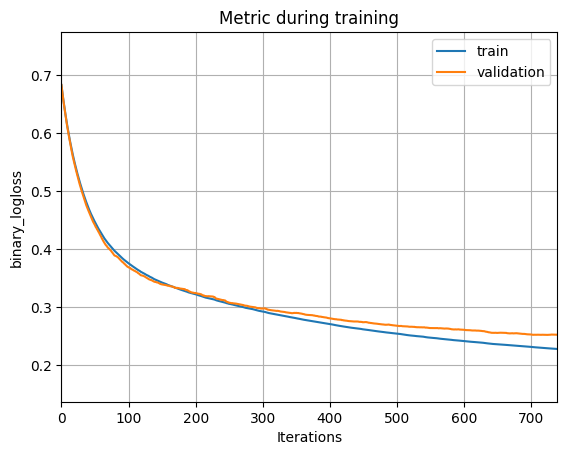

In [146]:
lgb.plot_metric(lgb_model)

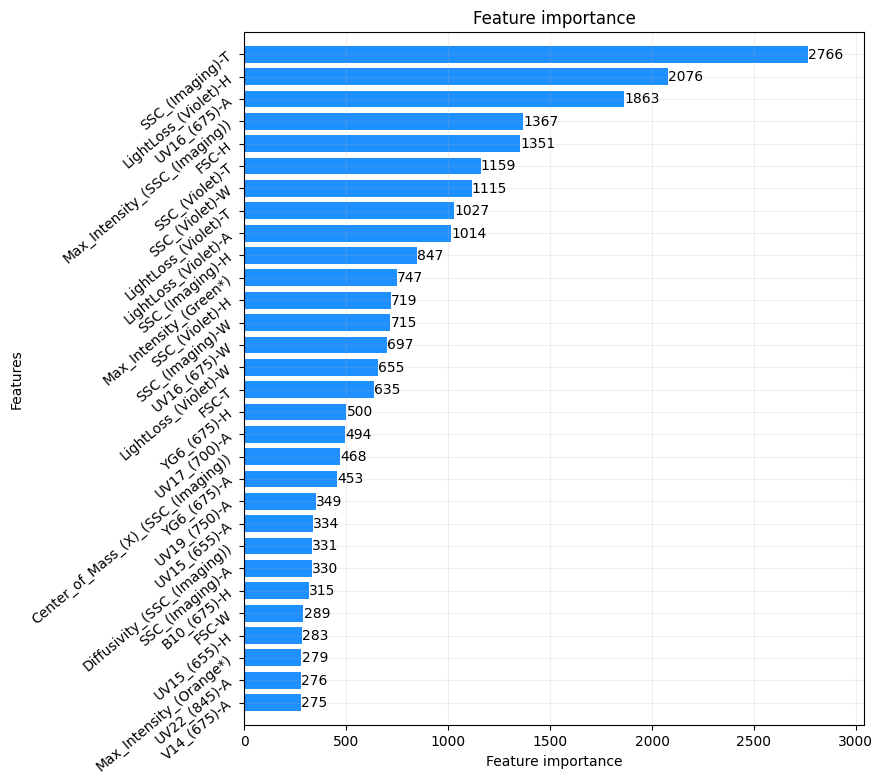

In [147]:
ax = lgb.plot_importance(
    lgb_model, max_num_features=30, importance_type="split",
    figsize=(8, 9), height=0.75,
    color="dodgerblue"
)
ax.yaxis.set_tick_params(rotation=40)
ax.grid(alpha=0.2)

In [148]:
# test model
# load train data
with open("./test_ds.bin", mode="rb") as f:
    data = pickle.load(f)

test_data = data["test_data"]
test_labels = data["test_labels"]
feature_names = data["feature_names"]

print(test_data.shape, test_labels.shape)

(37862, 448) (37862,)


In [149]:
predictions = lgb_model.predict(test_data, num_iteration=lgb_model.best_iteration_)

In [150]:
target_names = ["C.6818", "Emiliana Huxley"]

print(classification_report(test_labels, predictions, target_names=target_names))

                 precision    recall  f1-score   support

         C.6818       0.92      0.86      0.89     18917
Emiliana Huxley       0.87      0.93      0.90     18945

       accuracy                           0.90     37862
      macro avg       0.90      0.90      0.90     37862
   weighted avg       0.90      0.90      0.90     37862



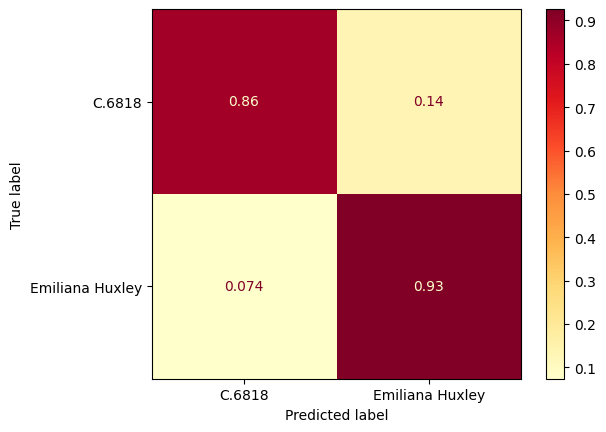

In [151]:
ConfusionMatrixDisplay.from_predictions(
    test_labels, predictions,
    display_labels=target_names,
    normalize="true", cmap="YlOrRd"
)

In [152]:
with open("lgb_model_448_cols.bin", mode="wb") as f:
    pickle.dump(lgb_model, f)

# lgb_model.booster_.dump_model(importance_type="split")

In [162]:
df_model_trees = lgb_model.booster_.trees_to_dataframe()
df_model_trees

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-S1,0-S3,None,UV16_(675)-A,24684.800781,1042.5,<=,left,None,-0.000242,0.000000,171638
1,0,2,0-S1,0-S5,0-S2,0-S0,UV16_(675)-A,33696.398438,-936.5,<=,left,None,0.007346,34368.200000,137473
2,0,3,0-S5,0-S21,0-S15,0-S1,UV16_(675)-A,1065.739990,-1213.5,<=,left,None,-0.033732,6480.250000,25921
3,0,4,0-S21,0-S32,0-S42,0-S5,SSC_(Imaging)-W,171.951004,1423.0,<=,left,None,-0.037695,5232.750000,20931
4,0,5,0-S32,0-S47,0-S34,0-S21,UV16_(675)-A,73.870697,-1435.5,<=,left,None,-0.037924,5212.250000,20849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84573,723,7,723-L15,None,None,723-S29,None,NaN,NaN,None,None,None,0.000156,1427.157913,13613
84574,723,7,723-L30,None,None,723-S29,None,NaN,NaN,None,None,None,-0.006346,142.089672,1397
84575,723,6,723-S30,723-L29,723-L31,723-S28,R2_(675)-A,11.918900,-581.5,<=,left,None,0.002032,1533.940000,21848
84576,723,7,723-L29,None,None,723-S30,None,NaN,NaN,None,None,None,-0.003811,127.057031,1368


In [163]:
df_model_trees.to_csv("model_trees.csv", index=False)

In [164]:
from IPython.display import HTML

graph = lgb.create_tree_digraph(
    lgb_model,
    tree_index=100,
    max_category_values=10,
    show_info=["split_gain"]
)
with open("model_tree_graph.svg", mode="w") as f:
    f.write(graph._repr_image_svg_xml())

HTML(graph._repr_image_svg_xml())

In [3]:
with open("lgb_model_448_cols.bin", mode="rb") as f:
    lgb_model = pickle.load(f)

<BarContainer object of 227 artists>

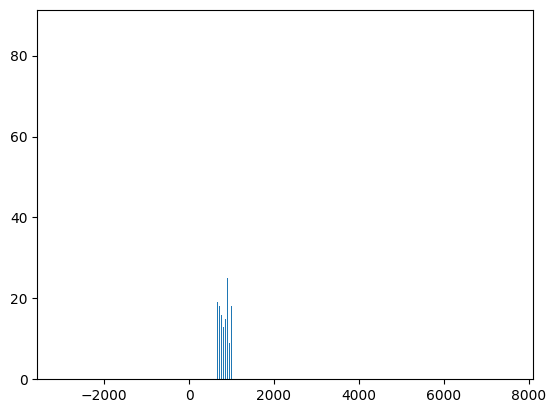

In [4]:
# hist, bins = lgb_model.booster_.get_split_value_histogram("SSC_(Imaging)-T")
hist, bins = lgb_model.booster_.get_split_value_histogram("UV16_(675)-A")
plt.bar(bins[:-1], hist, width=0.9)

In [7]:
hist

array([ 1,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  3,  0,  1,  0,  0,
        2,  6,  6,  5,  0,  1, 15, 62, 11, 17, 11, 19, 14, 87, 15,  8,  5,
       34, 53, 21, 14, 60, 25,  8, 41, 18, 15, 14, 18, 24, 16, 21, 19, 19,
       35, 18, 24, 20, 41, 30, 48, 27, 11,  1,  6,  6,  0,  3,  3,  3,  7,
        2,  3,  9, 16, 21, 23, 40, 22, 40, 18, 19, 19, 18, 16, 13, 15, 25,
        9, 18, 12, 16, 25,  0, 28, 35,  3, 68,  4, 21, 22, 49, 11, 24, 34,
       37,  8, 37,  5, 16,  7, 19,  2,  0,  2,  1,  1,  0, 14,  0,  1,  0,
        0,  1,  0,  0,  0,  0,  0,  4,  0,  2,  0,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  2,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0